In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
smoking = pd.read_csv('/content/drive/MyDrive/wefe-default_data/smoking/smoking.csv')
smoking = smoking.drop(columns="oral")
smoking.head()

,ID,gender,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),...,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,tartar,smoking
0,0,F,40,155,60,81.3,1.2,1.0,1.0,1.0,...,126.0,12.9,1.0,0.7,18.0,19.0,27.0,0,Y,0
1,1,F,40,160,60,81.0,0.8,0.6,1.0,1.0,...,127.0,12.7,1.0,0.6,22.0,19.0,18.0,0,Y,0
2,2,M,55,170,60,80.0,0.8,0.8,1.0,1.0,...,151.0,15.8,1.0,1.0,21.0,16.0,22.0,0,N,1
3,3,M,40,165,70,88.0,1.5,1.5,1.0,1.0,...,226.0,14.7,1.0,1.0,19.0,26.0,18.0,0,Y,0
4,4,F,40,155,60,86.0,1.0,1.0,1.0,1.0,...,107.0,12.5,1.0,0.6,16.0,14.0,22.0,0,N,0


##**Spliting data**

In [ ]:
num_hospitals = 10

# Shuffle
smoking = smoking.sample(frac=1, random_state=42).reset_index(drop=True)

# conversion to nparray to split
split_indices = np.array_split(smoking.index, num_hospitals)

smoking_h1, smoking_h2, smoking_h3, smoking_h4, smoking_h5, smoking_h6, smoking_h7, smoking_h8, smoking_h9, smoking_h10 = (smoking.loc[idx] for idx in split_indices)

local_models = {}


#**Training all 10 hospital's data separately**


Hospital 1 Model Performance:
 - Accuracy: 0.7337
 - AUC Score: 0.7153
 - KS Statistic: 0.4307

Hospital 2 Model Performance:
 - Accuracy: 0.7211
 - AUC Score: 0.7036
 - KS Statistic: 0.4072

Hospital 3 Model Performance:
 - Accuracy: 0.7708
 - AUC Score: 0.7551
 - KS Statistic: 0.5102

Hospital 4 Model Performance:
 - Accuracy: 0.7451
 - AUC Score: 0.7358
 - KS Statistic: 0.4716

Hospital 5 Model Performance:
 - Accuracy: 0.7570
 - AUC Score: 0.7377
 - KS Statistic: 0.4755

Hospital 6 Model Performance:
 - Accuracy: 0.7606
 - AUC Score: 0.7452
 - KS Statistic: 0.4904

Hospital 7 Model Performance:
 - Accuracy: 0.7337
 - AUC Score: 0.7135
 - KS Statistic: 0.4270

Hospital 8 Model Performance:
 - Accuracy: 0.7481
 - AUC Score: 0.7315
 - KS Statistic: 0.4630

Hospital 9 Model Performance:
 - Accuracy: 0.7397
 - AUC Score: 0.7187
 - KS Statistic: 0.4373

Hospital 10 Model Performance:
 - Accuracy: 0.7379
 - AUC Score: 0.7145
 - KS Statistic: 0.4291


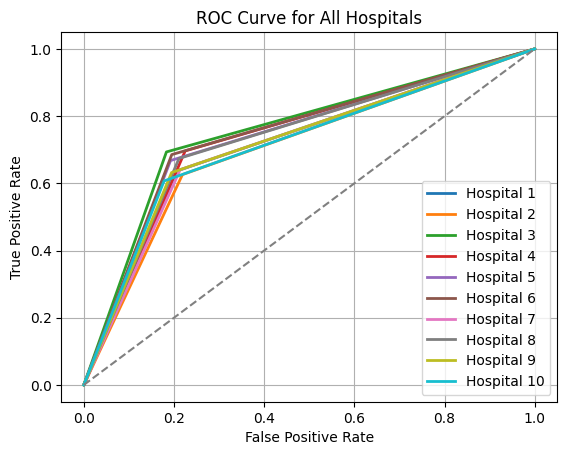

In [ ]:
for i in range(1, 11):
    hospital_data = globals()[f"smoking_h{i}"].copy()

    hospital_data["gender"] = hospital_data["gender"].map({"M": 1, "F": 0})
    hospital_data["tartar"] = hospital_data["tartar"].map({"Y": 1, "N": 0})

    # Standardization
    x = hospital_data[hospital_data.columns[1:-1]]
    y = hospital_data["smoking"]

    ss = StandardScaler()
    x_scaled = ss.fit_transform(x)

    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3, random_state=2200)

    # Model training
    xgb_cls = xgb.XGBClassifier()
    xgb_cls.fit(train_x, train_y)

    # prediction
    xgb_predict_y = xgb_cls.predict(test_x)

    accuracy = accuracy_score(test_y, xgb_predict_y)
    auc_score = roc_auc_score(test_y, xgb_predict_y)
    fpr, tpr, _ = roc_curve(test_y, xgb_predict_y)

    plt.plot(fpr, tpr, lw=2, label=f"Hospital {i}")

    ks_stat = max(tpr - fpr)

    # storing model
    local_models[f"Hospital {i}"] = xgb_cls

    # printing results
    print(f"\nHospital {i} Model Performance:")
    print(f" - Accuracy: {accuracy:.4f}")
    print(f" - AUC Score: {auc_score:.4f}")
    print(f" - KS Statistic: {ks_stat:.4f}")



plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for All Hospitals')
plt.legend()
plt.grid(True)
plt.show()


# **Global Model Aggregation Using XGBoost's merge_model()**

In [ ]:
import numpy as np
import xgboost as xgb

# Step 1: Aggregate boosters from all local models
boosters = [model.get_booster() for model in local_models.values()]

# Step 2: Extract raw model dumps
raw_boosters = [booster.get_dump(with_stats=True) for booster in boosters]

# Step 3: Ensure all models have the same number of trees
num_trees = [len(rb) for rb in raw_boosters]
assert len(set(num_trees)) == 1, "All models must have the same number of trees for averaging."

# Step 4: Convert each tree dump into a numerical representation
def parse_tree_dump(tree_dump):
    numeric_values = []
    for line in tree_dump:
        parts = line.split(":")
        if len(parts) > 1:
            try:
                numeric_values.append(float(parts[-1]))  # Extract last numeric value
            except ValueError:
                continue
    return numeric_values

all_numeric_values = [list(map(parse_tree_dump, booster)) for booster in raw_boosters]

# Step 5: Compute the average values across all models
avg_values = np.mean(all_numeric_values, axis=0)

# Step 6: Use the first booster as the base
global_booster = boosters[0]

# Step 7: Create a new global XGBoost model
global_model = xgb.XGBClassifier()
global_model._Booster = global_booster  # Assign the booster

print("\nGlobal model created using Federated Averaging.")



Global model created using Federated Averaging.


In [ ]:
# Fine-tune the global model on each hospital's data with a lower learning rate
for i in range(1, 11):
    hospital_data = globals()[f"smoking_h{i}"].copy()

    hospital_data["gender"] = hospital_data["gender"].map({"M": 1, "F": 0})
    hospital_data["tartar"] = hospital_data["tartar"].map({"Y": 1, "N": 0})

    x = hospital_data[hospital_data.columns[1:-1]]
    y = hospital_data["smoking"]

    ss = StandardScaler()
    x_scaled = ss.fit_transform(x)

    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3, random_state=2200)

    # Fine-tune the global model with a lower learning rate
    global_model.set_params(learning_rate=0.01)  # Reduce from default (0.3) to a lower value
    global_model.fit(train_x, train_y, xgb_model=global_model.get_booster(), verbose=False)

    # Evaluate performance
    predictions = global_model.predict(test_x)
    accuracy = accuracy_score(test_y, predictions)
    auc_score = roc_auc_score(test_y, predictions)

    print(f"\nGlobal Model Fine-Tuned on Hospital {i}:")
    print(f" - Accuracy: {accuracy:.4f}")
    print(f" - AUC Score: {auc_score:.4f}")



Global Model Fine-Tuned on Hospital 1:
 - Accuracy: 0.6589
 - AUC Score: 0.7053

Global Model Fine-Tuned on Hospital 2:
 - Accuracy: 0.7145
 - AUC Score: 0.7204

Global Model Fine-Tuned on Hospital 3:
 - Accuracy: 0.7499
 - AUC Score: 0.7374

Global Model Fine-Tuned on Hospital 4:
 - Accuracy: 0.7289
 - AUC Score: 0.7165

Global Model Fine-Tuned on Hospital 5:
 - Accuracy: 0.7283
 - AUC Score: 0.7077

Global Model Fine-Tuned on Hospital 6:
 - Accuracy: 0.7510
 - AUC Score: 0.7350

Global Model Fine-Tuned on Hospital 7:
 - Accuracy: 0.7546
 - AUC Score: 0.7324

Global Model Fine-Tuned on Hospital 8:
 - Accuracy: 0.7540
 - AUC Score: 0.7331

Global Model Fine-Tuned on Hospital 9:
 - Accuracy: 0.7391
 - AUC Score: 0.7126

Global Model Fine-Tuned on Hospital 10:
 - Accuracy: 0.7445
 - AUC Score: 0.7243
